# 0. SETUP

## 0.A. Imports and constants

In [40]:
!pip install -r './Requirements.txt'

In [41]:
from feedly.session import FeedlySession
from feedly.data import StreamOptions, Streamable
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import urllib3
urllib3.disable_warnings()

from tqdm import tqdm
import requests
from pyquery import PyQuery
import re
import gensim
from gensim.corpora import Dictionary
from sklearn.model_selection import cross_validate

In [42]:
k = 500

## 0.B. First tests of the API

In [43]:
token = "A_A2lqPARnik4gx7Dv6jWaEo-IkWqDGsCguzaXDnPNxsiHZPCR-EUdQ4t8fZjEKCaMcUR4cOEn0FsiIyaacIbiCVHCPdhAfDTCAB0O-OJPdoffJeSxCcgJCVuR64gPNJ4WvU8NbQerBA7rG7GIBm6vLTe8BVyAAQvt0zcW463M5X8hXHkWVXIyZiY2pQiddxkbEbjt_VLdvSnZwYrjZecB6FPdfin-MToyYuYaEi9-eHcpk:feedly"

In [44]:
sess = FeedlySession(auth=token)

In [45]:
# print the names of all your feeds (categories) and boards (tags)
print("Personal feeds:")
for category_uuid, category_data in sess.user.get_categories().items():
  print("\t", f'"{category_uuid}"', f"({category_data['label']})")
print("Personal boards:")
for tag_name in sess.user.get_tags():
  print("\t",f'"{tag_name}"')

Personal feeds:
	 "84ba8ab4-2a00-4af8-b574-3ed9e2f6a8d9" (Random)
	 "aa5c0982-1aa4-4598-b9d5-fd2f17c697d2" (AGI)
	 "d6be99dc-5a14-45f5-8d2a-9dd6937c6d93" (Start-up)
Personal boards:


# 1. DOWNLOAD DATA

## 1.A. Retrieve artciles from the stream

In [46]:
source_feed = "feed/http://feeds.harvardbusiness.org/harvardbusiness/"
base_query = f"/v3/streams/contents?streamId={source_feed}" 
articles = list(Streamable({'id': source_feed}, sess).stream_contents(options=StreamOptions(max_count=k)))

In [47]:
articles[199].json

{'id': 'RUSFMaap2epUB1Hxr7coT6Cd7n5A3BtYAIay0ExHdcs=_16934ddfe1b:b2c63a:b77f238b',
 'keywords': ['Social responsibility', 'Sustainability', 'Digital Article'],
 'originId': 'tag:blogs.harvardbusiness.org,2007-03-31:999.224925',
 'fingerprint': 'd5b540e5',
 'content': {'content': '<p>Protecting at-risk communities can be part of a strong environmental strategy.</p>\n<div>\n<a href="http://feeds.harvardbusiness.org/~ff/harvardbusiness?a=uJY6jvAFirs:73QGvybABeI:yIl2AUoC8zA"><img border="0" src="http://feeds.feedburner.com/~ff/harvardbusiness?d=yIl2AUoC8zA"></a> <a href="http://feeds.harvardbusiness.org/~ff/harvardbusiness?a=uJY6jvAFirs:73QGvybABeI:bcOpcFrp8Mo"><img border="0" src="http://feeds.feedburner.com/~ff/harvardbusiness?d=bcOpcFrp8Mo"></a>\n</div><img width="1" alt="" src="http://feeds.feedburner.com/~r/harvardbusiness/~4/uJY6jvAFirs" height="1">',
  'direction': 'ltr'},
 'title': 'What Would the Green New Deal Mean for Businesses?',
 'updated': 1551369612000,
 'crawled': 15513701

In [48]:
print("2) The other fields available are ",list(articles[199].json.keys()))

2) The other fields available are  ['id', 'keywords', 'originId', 'fingerprint', 'content', 'title', 'updated', 'crawled', 'published', 'canonical', 'origin', 'author', 'alternate', 'visual', 'unread', 'commonTopics', 'entities', 'engagement', 'webfeeds']


In [49]:
columns = ['id','keywords','content','title','canonical','visual','commonTopics','engagement','published']
l = len(columns)
data = np.zeros((k,l),dtype = object)

i=0
for ar in articles :
    for j in range(l):
        try :
            data[i,j] = ar.json[columns[j]]
        except:
            data[i,j] = 'impossible to get'
    i+=1
    

### I just store the 500 artciles in an array and then in a pandas Dataframe

In [50]:
df = pd.DataFrame(data,columns=columns)
df.head()

,id,keywords,content,title,canonical,visual,commonTopics,engagement,published
0,RUSFMaap2epUB1Hxr7coT6Cd7n5A3BtYAIay0ExHdcs=_1...,"[Technology, Talent management, Digital Article]",{'content': '<p>New devices offer less intrusi...,How Wearable AI Will Amplify Human Intelligence,[{'href': 'https://hbr.org/2019/04/how-wearabl...,{'edgeCacheUrl': 'https://lh3.googleuserconten...,"[{'id': 'nlp/f/topic/2457', 'label': 'wearable...",6073,1556632812000
1,RUSFMaap2epUB1Hxr7coT6Cd7n5A3BtYAIay0ExHdcs=_1...,"[Marketing, International business, Audio]","{'content': '<p>Kimberly Whitler, assistant pr...",How China Is Upending Western Marketing Practices,[{'href': 'https://hbr.org/ideacast/2019/04/ho...,{'edgeCacheUrl': 'https://lh3.googleuserconten...,"[{'id': 'nlp/f/topic/741', 'label': 'education...",5757,1556631032000
2,RUSFMaap2epUB1Hxr7coT6Cd7n5A3BtYAIay0ExHdcs=_1...,"[Internet, Regulation, Policy, Digital Article]",{'content': '<p>Digital infrastructure is best...,The U.S. Government Shouldn’t Run the Country’...,[{'href': 'https://hbr.org/2019/04/the-u-s-gov...,{'edgeCacheUrl': 'https://lh3.googleuserconten...,"[{'id': 'nlp/f/topic/3044', 'label': 'telecoms...",5717,1556629207000
3,RUSFMaap2epUB1Hxr7coT6Cd7n5A3BtYAIay0ExHdcs=_1...,"[Gender, Personnel policies, Digital Article]","{'content': '<p>Discrimination is widespread, ...",How Companies Can Support Breastfeeding Employees,[{'href': 'https://hbr.org/2019/04/how-compani...,{'edgeCacheUrl': 'https://lh3.googleuserconten...,"[{'id': 'nlp/f/topic/1734', 'label': 'pharma'}...",5806,1556625959000
4,RUSFMaap2epUB1Hxr7coT6Cd7n5A3BtYAIay0ExHdcs=_1...,"[Gender, Audio]",{'content': '<p>There are a lot of reasons wom...,The Upside of Working Motherhood,[{'href': 'https://hbr.org/podcast/2019/04/the...,{'edgeCacheUrl': 'https://lh3.googleuserconten...,"[{'id': 'nlp/f/topic/741', 'label': 'education...",5525,1556552036000


## 1.B. Retrieve complete articles

In [51]:
def getArticleFromUrl(url):
    r = requests.get(url)
    html = r.content
    pq = PyQuery(html)
    tag = pq('div.article')
    return(tag.text())

### It's a function to get the complete article from href url given in the canonical field : I get the article with the request module and then I parse it with the PyQuery module (It's possible to parse it automatically because we retrieve the article from the same website HBR so the format is the same, i.e. the article content can always be found in the div with class name "article")


In [52]:
j = 4 
articlesContent = np.zeros((k,1),dtype = object)

for i in tqdm(range(k)):
    url = data[i,j][0]['href']
    articlesContent[i,0] = getArticleFromUrl(url)

data = np.concatenate((data,articlesContent),axis = 1)
columns += ['content']
df = pd.DataFrame(data,columns=columns)
data[0,:]

100%|██████████| 500/500 [04:31<00:00,  2.05it/s]


array(['RUSFMaap2epUB1Hxr7coT6Cd7n5A3BtYAIay0ExHdcs=_16a6e93984d:1be21b:26ccdcf8',
       list(['Technology', 'Talent management', 'Digital Article']),
       {'content': '<p>New devices offer less intrusive, more intuitive ways to make humans smarter.</p>\n<div>\n<a href="http://feeds.harvardbusiness.org/~ff/harvardbusiness?a=hFA_WRlQvtY:rM1LrBvMBxc:yIl2AUoC8zA"><img border="0" src="http://feeds.feedburner.com/~ff/harvardbusiness?d=yIl2AUoC8zA"></a> <a href="http://feeds.harvardbusiness.org/~ff/harvardbusiness?a=hFA_WRlQvtY:rM1LrBvMBxc:bcOpcFrp8Mo"><img border="0" src="http://feeds.feedburner.com/~ff/harvardbusiness?d=bcOpcFrp8Mo"></a>\n</div><img width="1" alt="" src="http://feeds.feedburner.com/~r/harvardbusiness/~4/hFA_WRlQvtY" height="1">', 'direction': 'ltr'},
       'How Wearable AI Will Amplify Human Intelligence',
       list([{'href': 'https://hbr.org/2019/04/how-wearable-ai-will-amplify-human-intelligence', 'type': 'text/html'}]),
       {'edgeCacheUrl': 'https://lh3.googleu

## 1.C. First processing of the data

In [53]:
from gensim.parsing.preprocessing import preprocess_string,strip_multiple_whitespaces,strip_punctuation, strip_non_alphanum

filters = [strip_punctuation,strip_multiple_whitespaces,strip_non_alphanum]

firstTreatment = []

for i in range(k):
    firstTreatment.append(preprocess_string(data[i,-1],filters))

### We transform the raw article in a list of tokens and apply some filters to retrieve punctuation, non alphanumerical characters and multiple whitespaces

In [54]:
compteur = 0
upper = 0
for i in range(k):
    for word in firstTreatment[i]:
        if word[0].isupper():
            upper+=1
        compteur+=1

print("3) The ratio of the capitalized word to non­capitalized words is ",int(upper/compteur*10000)/100,"%")

3) The ratio of the capitalized word to non­capitalized words is  10.59 %


In [55]:
number = re.compile('\d+')
for i in range(k):
    for j in range(len(firstTreatment[i])):
        word = firstTreatment[i][j]
        firstTreatment[i][j] = number.sub('isanumber', word).lower()

### Maybe the number 50 is not important to know if an article is about leadership but maybe the fact that an article contains a certain amount of number in it can be meaningful, so we will just transform every number in the string "isanumber" to reduce the vocabulary while keeping useful information

In [56]:
data = np.concatenate((data,np.reshape(firstTreatment,(k,1))),axis = 1)
columns += ['tokens']
df = pd.DataFrame(data,columns=columns)
#df.head()

In [57]:
print(data[0,-1][:100])

['tara', 'moore', 'getty', 'images', 'imagine', 'that', 'your', 'team', 'is', 'meeting', 'to', 'decide', 'whether', 'to', 'continue', 'an', 'expensive', 'marketing', 'campaign', 'after', 'a', 'few', 'minutes', 'it', 'becomes', 'clear', 'that', 'nobody', 'has', 'the', 'metrics', 'on', 'hand', 'to', 'make', 'the', 'decision', 'you', 'chime', 'in', 'with', 'a', 'solution', 'and', 'ask', 'amazon', 's', 'virtual', 'assistant', 'alexa', 'to', 'back', 'you', 'up', 'with', 'information', 'alexa', 'how', 'many', 'users', 'did', 'we', 'convert', 'to', 'customers', 'last', 'month', 'with', 'campaign', 'a', 'and', 'alexa', 'responds', 'with', 'the', 'answer', 'you', 'just', 'amplified', 'your', 'team', 's', 'intelligence', 'with', 'ai', 'but', 'this', 'is', 'just', 'the', 'tip', 'of', 'the', 'iceberg', 'intelligence', 'amplification', 'is', 'the', 'use', 'of']


In [58]:
d = Dictionary(firstTreatment)

In [59]:
print("With that first preprocessing we get "+str(len(d))+" words in the vocabulary")

With that first preprocessing we get 20773 words in the vocabulary


In [60]:
len(d)/500

41.546

## 1.D. Other preprocessing step to reduce the number of words by using stemming

In [61]:
from gensim.parsing.preprocessing import stem_text

filters = [stem_text]

secondTreatment = []

for i in range(k):
    secondTreatment.append([])
    for word in firstTreatment[i]:
        secondTreatment[i].append(preprocess_string(word,filters)[0])

In [62]:
print(secondTreatment[0][:100])

['tara', 'moor', 'getti', 'imag', 'imagin', 'that', 'your', 'team', 'is', 'meet', 'to', 'decid', 'whether', 'to', 'continu', 'an', 'expens', 'market', 'campaign', 'after', 'a', 'few', 'minut', 'it', 'becom', 'clear', 'that', 'nobodi', 'ha', 'the', 'metric', 'on', 'hand', 'to', 'make', 'the', 'decis', 'you', 'chime', 'in', 'with', 'a', 'solut', 'and', 'ask', 'amazon', 's', 'virtual', 'assist', 'alexa', 'to', 'back', 'you', 'up', 'with', 'inform', 'alexa', 'how', 'mani', 'user', 'did', 'we', 'convert', 'to', 'custom', 'last', 'month', 'with', 'campaign', 'a', 'and', 'alexa', 'respond', 'with', 'the', 'answer', 'you', 'just', 'amplifi', 'your', 'team', 's', 'intellig', 'with', 'ai', 'but', 'thi', 'is', 'just', 'the', 'tip', 'of', 'the', 'iceberg', 'intellig', 'amplif', 'is', 'the', 'us', 'of']


In [63]:
d2 = Dictionary(secondTreatment)

In [64]:
print("We now get a vocabulary of size ",len(d2))

We now get a vocabulary of size  12541


### We divided the vocabulary size by almsot 2

In [65]:
data = np.concatenate((data,np.reshape(secondTreatment,(k,1))),axis = 1)

In [66]:
for i in range(k):
    
    if(data[i,-3]==""):
        print(i)
        data[i,0] = "toDelete"

136
142
144
154


In [67]:
data = data[~(data[:,0]=="toDelete")]
k = len(data)

### After passing threw the Dataframe list of tokens were converted into string so we had to reverse tranform

In [68]:
columns += ['tokensWithStemming']
df = pd.DataFrame(data,columns=columns)
df.to_csv('dataBase.csv')

## 1.E. Analyse words frequency

In [69]:
df = pd.read_csv('dataBase.csv')
del(df['Unnamed: 0'])
tab = np.array(df,dtype=object)

In [70]:
def stringToList(s):
    l = s.split("', '")
    l[0] = l[0][2:]
    l[-1] = l[-1][:-2]
    return(l)

In [71]:
for i in range(k):
    tab[i,-1] = stringToList(tab[i,-1])
    tab[i,-2] = stringToList(tab[i,-2])

### We just remove rows with no complete articles (probably the http request which failed at the beginning)

In [72]:
frequency = {}
vocab = list(d.values())
for word in vocab:
    frequency[word] = 0
for i in range(k):
    for word in tab[i,-2]:
        frequency[word]+=1

In [73]:
frequencies = sorted(frequency.items(), key=lambda x: x[1],reverse = True)

In [74]:
frequencies[:20]

[('the', 29947),
 ('to', 25436),
 ('and', 22413),
 ('of', 17561),
 ('a', 16258),
 ('that', 13931),
 ('in', 12169),
 ('you', 9351),
 ('is', 8032),
 ('s', 7871),
 ('it', 7834),
 ('i', 7512),
 ('for', 7297),
 ('with', 5251),
 ('they', 5157),
 ('are', 5136),
 ('we', 5111),
 ('isanumber', 5028),
 ('this', 4782),
 ('on', 4781)]

### We only get stopwords among the most frequent words... so we are going to remove them to get better insights

In [75]:
from gensim.parsing.preprocessing import remove_stopwords
importantWords = []
for i in range(300):
    word = frequencies[i][0]
    if(remove_stopwords(word) and len(word)>2):
        importantWords.append(word)

In [76]:
print(importantWords)

['isanumber', 'people', 'work', 'time', 'like', 'think', 'new', 'know', 'business', 'company', 'companies', 'data', 'team', 'need', 'way', 'want', 'women', 'going', 'employees', 'help', 'things', 'right', 'job', 'leaders', 'good', 'better', 'googletag', 'research', 'organization', 'feel', 'important', 'different', 'example', 'use', 'working', 'years', 'alison', 'change', 'performance', 'best', 'managers', 'person', 'lot', 'actually', 'kind', 'value', 'day', 'long', 'likely', 'beard', 'making', 'organizations', 'problem', 'said', 'high', 'management', 'customers', 'experience', 'world', 'ask', 'life', 'market', 'push', 'thing', 'look', 'information', 'sales', 'great', 'year', 'care', 'function', 'start', 'having', 'process', 'little', 'ways', 'boss', 'technology', 'says', 'come', 'strategy', 'hbr', 'point', 'create', 'images', 'based', 'learning', 'let', 'digital', 'firms', 'product', 'employee', 'big', 'questions', 'manager', 'amy', 'role', 'able', 'question', 'dan', 'teams', 'leadersh

In [77]:
print('leadership' in importantWords)
print('leader' in importantWords)
print('lead' in importantWords)

True
False
False


# 2. Create rule-based models

In [78]:
df = pd.read_csv('dataBase.csv')
del(df['Unnamed: 0'])
data = np.array(df)
columns = list(df.columns)

In [79]:
jtitle = columns.index("title")
def model1(document):
    return ('leadership'in document[jtitle].lower())

In [90]:
jtokens = columns.index("tokens")
def model2(document):
    return('leadership' in document[jtokens])

In [81]:
model = gensim.models.KeyedVectors.load_word2vec_format('lexvec.enwiki+newscrawl.300d.W.pos.vectors', binary=False)  

### To execute this cell you will have to got to https://github.com/alexandres/lexvec#pre-trained-vectors and download the vectors of size 398 MB

In [82]:
print(model.most_similar(positive=['leadership'],topn=10))

[('frontbench', 0.540550947189331), ('leaders', 0.5190237164497375), ('leaderships', 0.4795929491519928), ('competence', 0.4795462191104889), ('governance', 0.47358646988868713), ('organizational', 0.4725119173526764), ('grassroots', 0.4708701968193054), ('party', 0.4704243838787079), ('unity', 0.4684489965438843), ('chairmanship', 0.46583208441734314)]


### In wikidpedia leadership appears in the same context as these words so we're going to try to include some of them in the rules

In [83]:
def model3(document):
    counter = 0
    words = ['leadership','frontbench','leaders','leaderships','grassroots']
    for word in words:
        if((word in document[jtokens]) or (word in document[jtitle].lower())):
            counter +=1
    return counter>1

# 3. Build the gold dataset

In [84]:
df = pd.read_csv('dataBase.csv')
del(df['Unnamed: 0'])
data = np.array(df)
columns = list(df.columns)

In [102]:
classe = np.zeros((k,1))
jkeywords = columns.index("keywords")
jtopics = columns.index("commonTopics")
for i in range(k):
    if('leadership' in data[i,jkeywords].lower()):
        classe[i]=1       
    if('leadership' in data[i,jtopics].lower()):
        classe[i]=1
        
dfclasse = pd.DataFrame(classe)
dfclasse.to_csv('classe.csv')

### There are 2 fields keywords and commonTopics which could correspond to "tags" so we will use both

In [86]:
np.mean(classe)

0.24798387096774194

### The dataset is unbalanced, only 1/4 of the articles seems to be about leadership

# 4. Evaluation

In [103]:
df = pd.read_csv('dataBase.csv')
del(df['Unnamed: 0'])
dfclasse = pd.read_csv('classe.csv')
del(dfclasse['Unnamed: 0'])
data = np.array(df)
classe = np.array(dfclasse)
columns = list(df.columns)
for i in range(k):
    data[i,-1] = stringToList(data[i,-1])
    data[i,-2] = stringToList(data[i,-2])

In [104]:
def predict(x,model):
    n,l = x.shape
    predictions = []
    for i in range(n):
        predictions.append(model(x[i,:]))
    return(predictions)
    

### That's just a function which returns the predictions of model on dataset x

In [105]:
def evaluateModels(data,classe):
    models = [model1,model2,model3]
    for i in range(3):
        ypredict = predict(data,models[i])
        print('--')
        print("precision of model "+str(i+1)+" :", (1-np.mean(abs(ypredict-classe)))*100)
        print("mean of predicted values :",np.mean(ypredict) )

evaluateModels(data,classe)

--
precision of model 1 : 74.59189646201874
mean of predicted values : 0.012096774193548387
--
precision of model 2 : 60.97489594172737
mean of predicted values : 0.28225806451612906
--
precision of model 3 : 64.22671696149844
mean of predicted values : 0.21774193548387097


### Model 1 seems to be better in term of precision biut that's only because the dataset is unbalanced and this model almost never predict class 1 
### Let's see what happends if we convert the datasete in a balanced one by deleting some class 0 sample for example

In [106]:
import random as rd
for i in range(k):
    if(not classe[i]):
        if(rd.random()>0.33):
            data[i,0]='toDelete'
            classe[i]=-1

balancedData = data[~(data[:,0] == 'toDelete')]      
balancedClasse = classe[~(classe[:]==-1)]



In [107]:
np.mean(balancedClasse)

0.4939759036144578

In [108]:
evaluateModels(balancedData,balancedClasse)

--
precision of model 1 : 53.012048192771076
mean of predicted values : 0.024096385542168676
--
precision of model 2 : 67.06827309236948
mean of predicted values : 0.3413654618473896
--
precision of model 3 : 66.26506024096386
mean of predicted values : 0.285140562248996


### Now the best models seem to be the models based on the body of the article
### So we can't conclude wich model is better, it actually depends on what is the metric considered which depends on the goal of the model / how we would use the model, they all have different false positive rate/ true positive rate/ false negative rate/ and so on

# 5. TFIDF - LR

## 5.A. Vectorization

In [322]:
df = pd.read_csv('dataBase.csv')
del(df['Unnamed: 0'])
dfclasse = pd.read_csv('classe.csv')
del(dfclasse['Unnamed: 0'])
data = np.array(df)
classe = np.array(dfclasse)
columns = list(df.columns)
for i in range(k):
    data[i,-1] = stringToList(data[i,-1])
    data[i,-2] = stringToList(data[i,-2])

In [323]:
from sklearn.feature_extraction.text import TfidfVectorizer

X = []
for i in range(k):
    X.append(' '.join(data[i,-1]))

vectorizer = TfidfVectorizer(max_df=0.7,min_df=0.01)
X = vectorizer.fit_transform(X)

### We use the tfidf vectorizer of sklearn and store the vectors in X

In [324]:
X.shape

(496, 4337)

## 5.B. Dimensionality reduction

In [325]:
from sklearn.decomposition import TruncatedSVD

tsvd = TruncatedSVD(n_components = 496)
X2 = tsvd.fit_transform(X)
print(len(tsvd.explained_variance_))

496


In [326]:
X = X.todense()

In [327]:
from sklearn.decomposition import PCA
n,l = X.shape
pca = PCA(n_components=496)
pca.fit(X)
variances = pca.explained_variance_ratio_
variancesSum = [np.sum(variances[:i]) for i in range(500)]

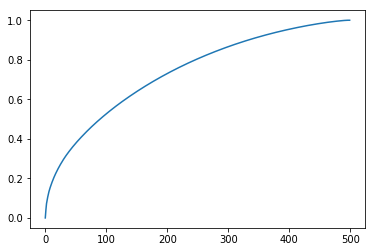

In [328]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(variancesSum)
plt.show()
    

In [329]:
pca = PCA(n_components=300)
X = pca.fit_transform(X)

## 5.C. Evaluation of the first models

In [353]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold as SK
clf = LogisticRegression(random_state=0, solver='lbfgs')
scores = cross_val_score(clf,X,classe.ravel(),cv=SK(shuffle=True,n_splits=5))
print(scores)
print(np.mean(scores))

[0.76       0.71       0.81       0.78571429 0.82653061]
0.7784489795918368


In [354]:
clf = LogisticRegression(random_state=0, solver='lbfgs')
scores = cross_val_score(clf,X2,classe.ravel(),cv=SK(shuffle=True,n_splits=5))
print(scores)
print(np.mean(scores))

[0.8        0.74       0.83       0.74489796 0.81632653]
0.7862448979591837


In [361]:
clf = LogisticRegression(random_state=1,solver='liblinear',class_weight='balanced',max_iter=1000,C=1)
scores = cross_val_score(clf,X,classe.ravel(),cv=SK(shuffle=True,n_splits=5))
print(scores)
print(np.mean(scores))

[0.77       0.83       0.73       0.82653061 0.78571429]
0.7884489795918367


### Not significative improvment by tuning by hand the model

## 5.D. Try to improve the model 

In [268]:
df = pd.read_csv('dataBase.csv')
del(df['Unnamed: 0'])
dfclasse = pd.read_csv('classe.csv')
del(dfclasse['Unnamed: 0'])
data = np.array(df)
classe = np.array(dfclasse)
columns = list(df.columns)
for i in range(k):
    data[i,-1] = stringToList(data[i,-1])
    data[i,-2] = stringToList(data[i,-2])

In [269]:
X = data[:,-1]

In [270]:
def transformX5(X,classe):
    X5 = []
    y5 = []
    k=len(X)
    for i in range(k):
        l = np.array(data[i,-1])
        n = len(l)
        indexes = [j for j in range(n)]
        rd.shuffle(indexes)
        naux = n//4
        for j in range(4):
            indexesaux = indexes[j*naux:(j+1)*naux]
            laux = l[indexesaux]
            X5.append(laux)
            y5.append(classe[i])

    return(X5,y5)

In [271]:
X5,classe5 = transformX5(X,classe)
X = []
for i in range(len(X5)):
    X.append(' '.join(X5[i]))

vectorizer = TfidfVectorizer(max_df=0.7,min_df=0.01)
X = vectorizer.fit_transform(X)
n,l = X.shape

In [272]:
X = X.todense()
pca = PCA(n_components=300)
X = pca.fit_transform(X)
classe5 = np.array(classe5).reshape((n,))

In [273]:
xtrain,xtest,ytrain,ytest = train_test_split(X,classe5,test_size = 0.2,shuffle=False)

In [274]:
xtrain,ytrain = sklearn.utils.shuffle(xtrain,ytrain)
clf = LogisticRegression(random_state=0, solver='lbfgs')
clf.fit(xtrain,ytrain)
clf.score(xtest,ytest)

0.7632241813602015

In [284]:
for counter in range(1,5):
    true = 0
    predictions = clf.predict(xtest)
    for i in range(396//4):
        count = 0
        for j in range(1,5):
            if(predictions[-(i*4+j)]):
                count+=1
        true += (count>=counter)==ytest[-(i*4+1)]

    print(true/99)

0.7171717171717171
0.7676767676767676
0.7777777777777778
0.7878787878787878


## Just some insights about articles length

In [259]:
longueurs = [len(data[i,-1]) for i in range(k)]

In [265]:
np.max(longueurs)

10018

In [260]:
np.mean(longueurs)

1527.975806451613

In [261]:
np.argmin(longueurs)

402

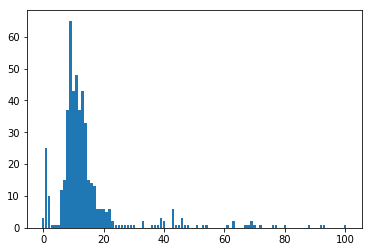

In [266]:
y = [0 for j in range(101)]
x = [j for j in range(101)]
for i in range(k):
    y[longueurs[i]//100]+=1

plt.figure()
plt.bar(x,y)
plt.show()

In [267]:
y[:6]

[3, 25, 10, 1, 1, 1]